In [1]:
import numpy as np
import cv2 as cv
import os
from google.colab.patches import cv2_imshow

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")

    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"이미지 로드에 실패했습니다: {image_path}")

    return image

def detect_damage_flann(original_path, damaged_path, factor=0.7):
    try:
        img1 = load_image(original_path)
        img2 = load_image(damaged_path)
    except (FileNotFoundError, ValueError) as e:
        print(f"오류: {e}")
        return None, None

    # SIFT 특징점 검출기 생성
    sift = cv.SIFT_create()

    # 키포인트와 디스크립터 추출
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 디스크립터 존재 확인
    if des1 is None or des2 is None:
        print("오류: 하나 또는 두 이미지에서 디스크립터를 찾을 수 없습니다.")
        return None, None

    # FLANN 매처 파라미터 설정
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN 매처 생성 및 매칭
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test를 사용하여 좋은 매치 선별
    good_matches = []
    for m, n in matches:
        if m.distance < factor * n.distance:
            good_matches.append(m)

    # 매칭되지 않은 키포인트 찾기 (잠재적 손상)
    matched_kp2 = set([match.trainIdx for match in good_matches])
    unmatched_kp2 = set(range(len(kp2))) - matched_kp2

    # 결과 이미지 생성
    img_result = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # 손상 영역 표시 (빨간색으로)
    for idx in unmatched_kp2:
        x, y = map(int, kp2[idx].pt)
        cv.circle(img_result, (img1.shape[1] + x, y), 5, (0, 0, 255), -1)

    # 손상 정도 계산
    damage_ratio = len(unmatched_kp2) / len(kp2) if kp2 else 0

    return img_result, damage_ratio

def draw_keypoints(image, keypoints):
    return cv.drawKeypoints(image, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

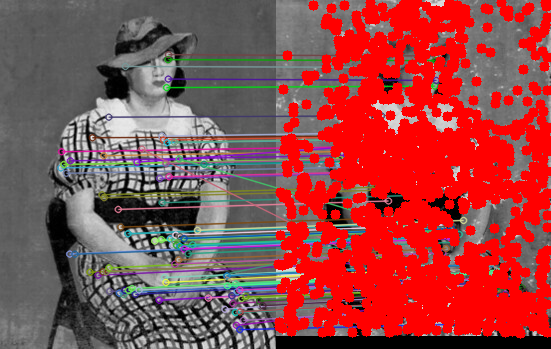

손상 정도: 95.78%


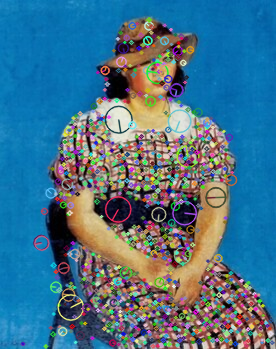

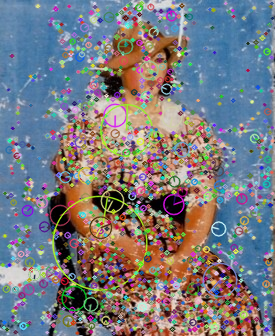

In [ ]:
original_path = '/content/drive/MyDrive/KeyPoint/images/origin.png'
damaged_path = '/content/drive/MyDrive/KeyPoint/images/impairment.png'

result, damage_ratio = detect_damage_flann(original_path, damaged_path)

if result is not None and damage_ratio is not None:
    # 결과 출력
    cv2_imshow(result)
    print(f"손상 정도: {damage_ratio:.2%}")

    # 키포인트 시각화
    try:
        original = cv.imread(original_path)
        damaged = cv.imread(damaged_path)

        sift = cv.SIFT_create()
        kp_original = sift.detect(original, None)
        kp_damaged = sift.detect(damaged, None)

        img_original_kp = draw_keypoints(original, kp_original)
        img_damaged_kp = draw_keypoints(damaged, kp_damaged)

        cv2_imshow(img_original_kp)
        cv2_imshow(img_damaged_kp)
    except Exception as e:
        print(f"키포인트 시각화 중 오류 발생: {e}")
else:
    print("손상 감지에 실패했습니다.")

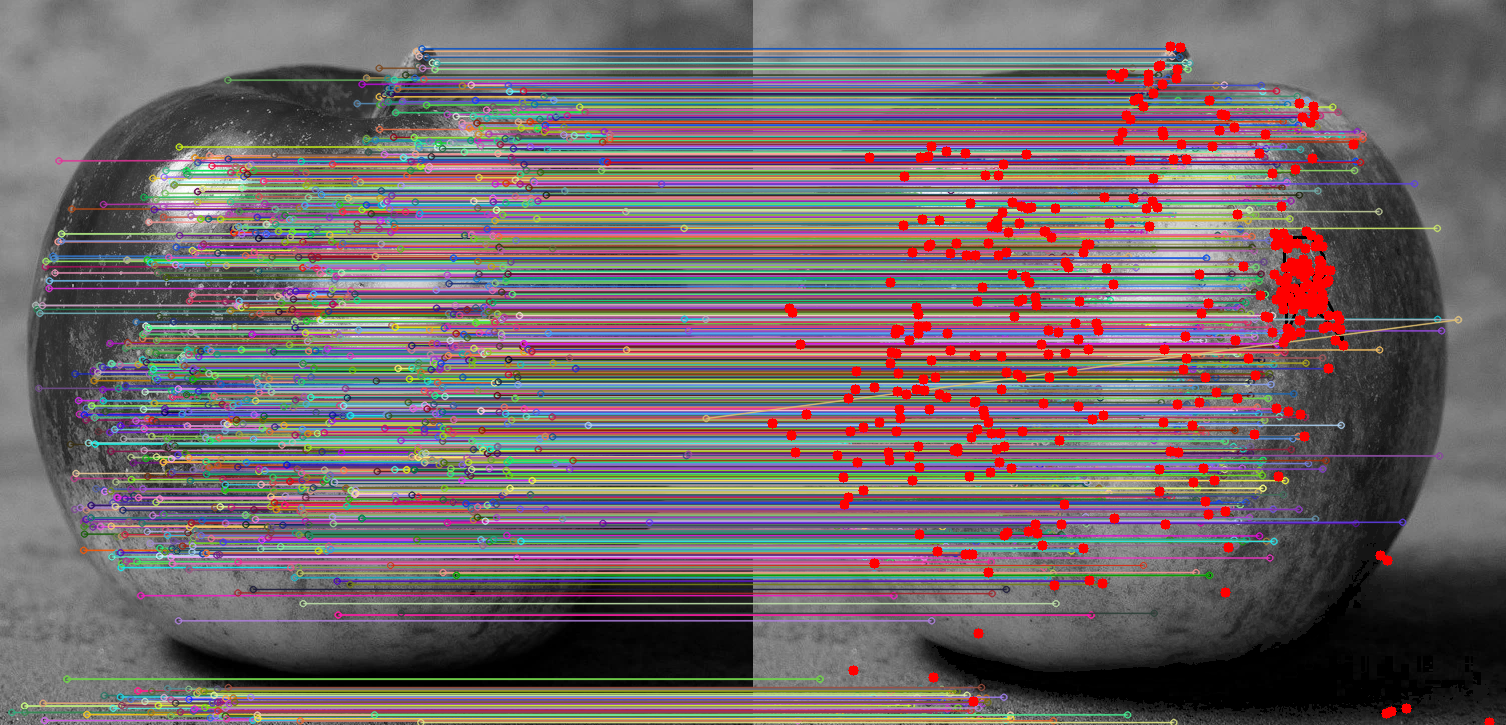

손상 정도: 25.01%


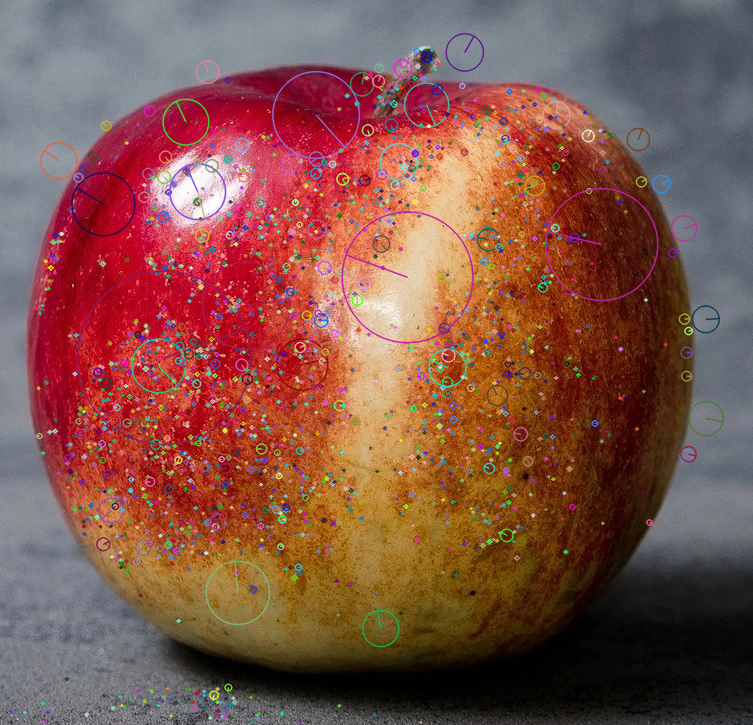

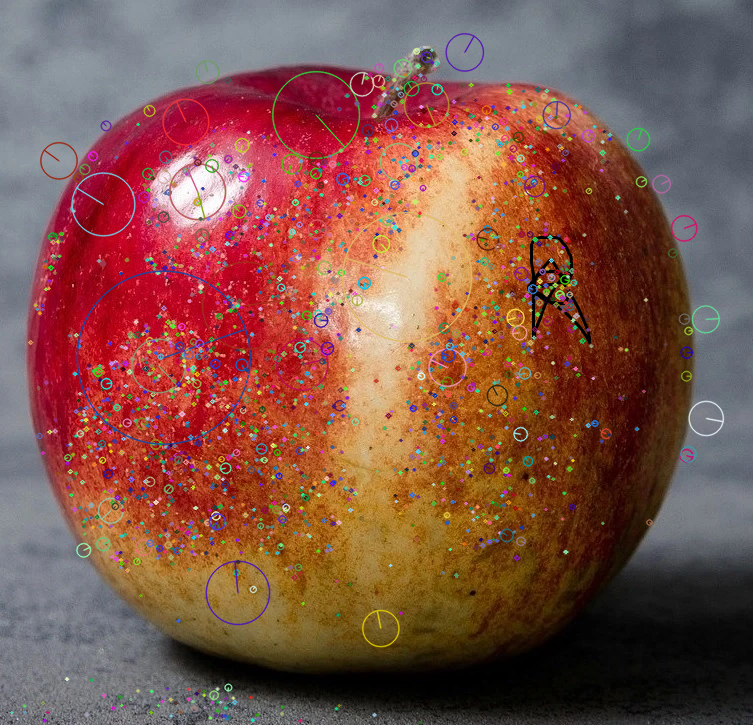

In [2]:
original_path = '/content/drive/MyDrive/KeyPoint/images/apple.jpg'
damaged_path = '/content/drive/MyDrive/KeyPoint/images/apple2.png'

result, damage_ratio = detect_damage_flann(original_path, damaged_path)

if result is not None and damage_ratio is not None:
    # 결과 출력
    cv2_imshow(result)
    print(f"손상 정도: {damage_ratio:.2%}")

    # 키포인트 시각화
    try:
        original = cv.imread(original_path)
        damaged = cv.imread(damaged_path)

        sift = cv.SIFT_create()
        kp_original = sift.detect(original, None)
        kp_damaged = sift.detect(damaged, None)

        img_original_kp = draw_keypoints(original, kp_original)
        img_damaged_kp = draw_keypoints(damaged, kp_damaged)

        cv2_imshow(img_original_kp)
        cv2_imshow(img_damaged_kp)
    except Exception as e:
        print(f"키포인트 시각화 중 오류 발생: {e}")
else:
    print("손상 감지에 실패했습니다.")